- Guzmán Pérez Karla Isela
- Velasco Avila Cristopher

# Ejercicio 2: Análisis de condiciones de vivienda en México usando datos del INEGI
## Descripción:
Usar datos de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) del INEGI
para analizar las condiciones de vivienda (material del techo, acceso al agua, número de
cuartos, etc.) y predecir si una vivienda se encuentra en una situación de carencia
habitacional.

In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import pyarrow

Carga y exploración general de los datos

Al igual que el ejercicio 1, comenzamos importando el dataset de las viviendas para observar los tipos de datos, las columnas y los registros disponibles. También verificamos si hay valores nulos y cómo se distribuyen los datos.



In [3]:
data = pl.read_csv(
	"viviendas.csv",
	schema_overrides={"tipo_viv": pl.Utf8, "combustible": pl.Utf8},
	null_values=["&"]
)
data

folioviv,tipo_viv,mat_pared,mat_techos,mat_pisos,antiguedad,antigua_ne,cocina,cocina_dor,cuart_dorm,num_cuarto,disp_agua,dotac_agua,excusado,uso_compar,sanit_agua,biodigest,bano_comp,bano_excus,bano_regad,drenaje,disp_elect,focos_inca,focos_ahor,combustible,estufa_chi,eli_basura,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,num_dueno1,hog_dueno1,num_dueno2,hog_dueno2,escrituras,lavadero,fregadero,regadera,tinaco_azo,cisterna,pileta,calent_sol,calent_gas,medidor_luz,bomba_agua,tanque_gas,aire_acond,calefacc,tot_resid,tot_hom,tot_muj,tot_hog,ubica_geo,tam_loc,est_socio,est_dis,upm,factor,procaptar
i64,str,i64,i64,i64,str,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
100005002,"""1""",8,10,3,"""30""",""" """,1,"""2""",2,4,1,1,1,2,1,2,1,0,0,1,1,0,8,"""3""",""" """,3,4,""" ""","""4000""",""" """,""" ""","""1""","""2""","""1""","""01""","""1""",""" """,""" ""","""1""",2,1,1,1,1,2,1,1,1,1,2,2,2,3,0,3,1,1001,1,4,3,1,206,0
100005003,"""1""",8,10,3,"""15""",""" """,1,"""2""",3,5,1,1,1,2,1,2,3,1,0,1,1,0,9,"""4""",""" """,3,1,"""8500""",""" """,""" ""","""1""",""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,1,1,1,1,2,1,1,1,1,1,2,2,2,1,1,1,1001,1,4,3,1,206,0
100005004,"""1""",8,10,3,"""25""",""" """,1,"""2""",3,7,1,1,1,2,1,2,2,1,0,1,1,0,10,"""3""",""" """,3,4,""" ""","""10000""",""" """,""" ""","""1""","""2""","""5""","""01""","""1""",""" """,""" ""","""1""",1,1,1,1,1,1,1,1,1,1,2,2,2,3,2,1,1,1001,1,4,3,1,206,0
100012002,"""1""",8,10,3,"""50""",""" """,1,"""2""",4,6,1,1,1,2,1,2,2,0,0,1,1,9,8,"""4""",""" """,3,4,""" ""","""5000""",""" """,""" ""","""1""","""2""","""1""","""01""","""1""",""" """,""" ""","""1""",1,1,1,1,1,2,1,1,1,1,2,2,2,5,3,2,2,1001,1,3,2,2,167,0
100012004,"""1""",8,10,3,"""45""",""" """,1,"""2""",3,4,1,1,1,2,1,2,2,1,0,1,1,0,17,"""3""",""" """,3,4,""" ""","""3000""",""" """,""" ""","""1""","""2""","""2""","""02""","""1""",""" """,""" ""","""1""",2,1,1,1,1,2,2,1,1,1,2,2,2,4,2,2,1,1001,1,3,2,2,167,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3260797907,"""1""",8,3,2,"""30""",""" """,1,"""2""",1,3,1,1,1,2,1,2,1,0,0,1,1,0,5,"""3""",""" """,1,1,"""800""",""" """,""" ""","""1""",""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,2,1,1,1,2,1,2,1,2,2,2,2,3,2,1,1,32046,4,2,560,10232,123,0
3260797908,"""1""",8,3,2,"""30""",""" """,1,"""2""",2,4,1,1,1,2,1,2,1,0,0,1,1,0,7,"""3""",""" """,1,5,""" ""","""1000""",""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,2,1,1,2,2,2,1,1,2,2,2,2,3,1,2,1,32046,4,2,560,10232,123,0
3260797909,"""1""",7,10,2,""" ""","""1""",1,"""2""",1,3,1,1,1,2,1,2,1,0,0,1,1,0,5,"""3""",""" """,1,1,"""800""",""" """,""" ""","""1""",""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,1,1,1,2,2,1,2,1,2,2,2,2,4,2,2,1,32046,4,2,560,10232,123,0


In [4]:
# Mostrar tipos de datos de cada columna
columns = data.columns
columns

['folioviv',
 'tipo_viv',
 'mat_pared',
 'mat_techos',
 'mat_pisos',
 'antiguedad',
 'antigua_ne',
 'cocina',
 'cocina_dor',
 'cuart_dorm',
 'num_cuarto',
 'disp_agua',
 'dotac_agua',
 'excusado',
 'uso_compar',
 'sanit_agua',
 'biodigest',
 'bano_comp',
 'bano_excus',
 'bano_regad',
 'drenaje',
 'disp_elect',
 'focos_inca',
 'focos_ahor',
 'combustible',
 'estufa_chi',
 'eli_basura',
 'tenencia',
 'renta',
 'estim_pago',
 'pago_viv',
 'pago_mesp',
 'tipo_adqui',
 'viv_usada',
 'tipo_finan',
 'num_dueno1',
 'hog_dueno1',
 'num_dueno2',
 'hog_dueno2',
 'escrituras',
 'lavadero',
 'fregadero',
 'regadera',
 'tinaco_azo',
 'cisterna',
 'pileta',
 'calent_sol',
 'calent_gas',
 'medidor_luz',
 'bomba_agua',
 'tanque_gas',
 'aire_acond',
 'calefacc',
 'tot_resid',
 'tot_hom',
 'tot_muj',
 'tot_hog',
 'ubica_geo',
 'tam_loc',
 'est_socio',
 'est_dis',
 'upm',
 'factor',
 'procaptar']

Se tiene una combinación de datos en forma de cadena de texto y numerico, lo que puede complicar el analisis. Posteriormente se va a considerar tipos de datos para castear.

In [5]:
# Cantidad de valores nulos por columna
nulos = data.null_count()
nulos

folioviv,tipo_viv,mat_pared,mat_techos,mat_pisos,antiguedad,antigua_ne,cocina,cocina_dor,cuart_dorm,num_cuarto,disp_agua,dotac_agua,excusado,uso_compar,sanit_agua,biodigest,bano_comp,bano_excus,bano_regad,drenaje,disp_elect,focos_inca,focos_ahor,combustible,estufa_chi,eli_basura,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,num_dueno1,hog_dueno1,num_dueno2,hog_dueno2,escrituras,lavadero,fregadero,regadera,tinaco_azo,cisterna,pileta,calent_sol,calent_gas,medidor_luz,bomba_agua,tanque_gas,aire_acond,calefacc,tot_resid,tot_hom,tot_muj,tot_hog,ubica_geo,tam_loc,est_socio,est_dis,upm,factor,procaptar
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,107,0,0,1,0,0,0,0,0,0,0,6848,0,1729,1729,1729,1729,1729,1729,0,0,471,471,4,0,0,0,0,0,0,0,0,0,442,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Gracias al metodo null_count podemos ver que hay algunos valores nulos en las columnas. Posteriormente se van a eliminar estas filas para tener datos mas limpios

In [ ]:
data.tail()

folioviv,tipo_viv,mat_pared,mat_techos,mat_pisos,antiguedad,antigua_ne,cocina,cocina_dor,cuart_dorm,num_cuarto,disp_agua,dotac_agua,excusado,uso_compar,sanit_agua,biodigest,bano_comp,bano_excus,bano_regad,drenaje,disp_elect,focos_inca,focos_ahor,combustible,estufa_chi,eli_basura,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,num_dueno1,hog_dueno1,num_dueno2,hog_dueno2,escrituras,lavadero,fregadero,regadera,tinaco_azo,cisterna,pileta,calent_sol,calent_gas,medidor_luz,bomba_agua,tanque_gas,aire_acond,calefacc,tot_resid,tot_hom,tot_muj,tot_hog,ubica_geo,tam_loc,est_socio,est_dis,upm,factor,procaptar
i64,str,i64,i64,i64,str,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3260797907,"""1""",8,3,2,"""30""",""" """,1,"""2""",1,3,1,1,1,2,1,2,1,0,0,1,1,0,5,"""3""",""" """,1,1,"""800""",""" """,""" ""","""1""",""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,2,1,1,1,2,1,2,1,2,2,2,2,3,2,1,1,32046,4,2,560,10232,123,0
3260797908,"""1""",8,3,2,"""30""",""" """,1,"""2""",2,4,1,1,1,2,1,2,1,0,0,1,1,0,7,"""3""",""" """,1,5,""" ""","""1000""",""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,2,1,1,2,2,2,1,1,2,2,2,2,3,1,2,1,32046,4,2,560,10232,123,0
3260797909,"""1""",7,10,2,""" ""","""1""",1,"""2""",1,3,1,1,1,2,1,2,1,0,0,1,1,0,5,"""3""",""" """,1,1,"""800""",""" """,""" ""","""1""",""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,1,1,1,2,2,1,2,1,2,2,2,2,4,2,2,1,32046,4,2,560,10232,123,0
3260797910,"""1""",7,10,3,"""40""",""" """,1,"""2""",1,4,1,1,1,2,1,2,2,0,0,1,1,0,28,"""3""",""" """,1,4,""" ""","""3000""",""" """,""" ""","""3""",""" ""","""5""","""02""","""1""",""" """,""" ""","""1""",1,1,1,1,2,2,1,1,1,2,1,2,2,2,1,1,1,32046,4,2,560,10232,123,0
3260797912,"""1""",7,7,3,""" ""","""1""",1,"""2""",1,5,1,1,1,2,1,2,1,0,0,1,1,0,8,"""3""",""" """,1,2,""" ""","""800""",""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,1,1,1,2,2,2,2,1,2,2,1,2,3,1,2,1,32046,4,2,560,10232,123,0


Este es  un ejemplo de las primeras filas del dataset. Probablemente no se necesiten todas las columnas, sin embargo, es necesario considerar el problema de los tipos

## Limpieza básica.


Para la limpieza, simplemente se van a considerar las columnas que probablemente no sean necesarias para el analisis, incluyendo las que indican propietarios por medio de ID's, y las columnas que usen valores de texto.

In [ ]:
erase=["folioviv","antiguedad","antigua_ne","renta","estim_pago","ubica_geo","upm","factor"]

data_fixed = data.drop_nulls()
data_fixed.describe()

# Eliminando columnas que no usamos
data_fixed = data_fixed.drop(erase)

## Análisis exploratorio


Debido a que no hay nua columna objetivo para usarse como Y, se va a considerar una nueva columna que indique si la vivienda tiene o no acceso a servicios basicos, y ademas, considerar elementos como los materiales de construcción y las condiciones en que se encuentran las viviendas.

In [8]:
data_with_y = data_fixed.with_columns(
    (
        (
            pl.col("mat_pared").is_in([1, 2, 3, 4, 5, 6]) |
            pl.col("mat_techos").is_in([1, 2, 3, 4, 5, 6]) |
            (pl.col("mat_pisos") == 1) |
            (pl.col("disp_agua") >= 3) |
            (pl.col("dotac_agua") >= 3) |
            (pl.col("drenaje") >= 3) |
            (pl.col("disp_elect") == 5) |
            (pl.col("excusado") == 2) |
            (pl.col("sanit_agua") == 3) |
            pl.col("combustible").is_in(["1", "2"]) |
            pl.col("eli_basura").is_in([4, 5, 6, 7, 8])
        ).cast(pl.Int8)
    ).alias("carencia_habitacional")
)
data_with_y.tail()


tipo_viv,mat_pared,mat_techos,mat_pisos,cocina,cocina_dor,cuart_dorm,num_cuarto,disp_agua,dotac_agua,excusado,uso_compar,sanit_agua,biodigest,bano_comp,bano_excus,bano_regad,drenaje,disp_elect,focos_inca,focos_ahor,combustible,estufa_chi,eli_basura,tenencia,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,num_dueno1,hog_dueno1,num_dueno2,hog_dueno2,escrituras,lavadero,fregadero,regadera,tinaco_azo,cisterna,pileta,calent_sol,calent_gas,medidor_luz,bomba_agua,tanque_gas,aire_acond,calefacc,tot_resid,tot_hom,tot_muj,tot_hog,tam_loc,est_socio,est_dis,procaptar,carencia_habitacional
str,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i8
"""1""",8,3,2,1,"""2""",1,3,1,1,1,2,1,2,1,0,0,1,1,0,5,"""3""",""" """,1,1,""" ""","""1""",""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,2,1,1,1,2,1,2,1,2,2,2,2,3,2,1,1,4,2,560,0,1
"""1""",8,3,2,1,"""2""",2,4,1,1,1,2,1,2,1,0,0,1,1,0,7,"""3""",""" """,1,5,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,2,1,1,2,2,2,1,1,2,2,2,2,3,1,2,1,4,2,560,0,1
"""1""",7,10,2,1,"""2""",1,3,1,1,1,2,1,2,1,0,0,1,1,0,5,"""3""",""" """,1,1,""" ""","""1""",""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,1,1,1,2,2,1,2,1,2,2,2,2,4,2,2,1,4,2,560,0,0
"""1""",7,10,3,1,"""2""",1,4,1,1,1,2,1,2,2,0,0,1,1,0,28,"""3""",""" """,1,4,""" """,""" ""","""3""",""" ""","""5""","""02""","""1""",""" """,""" ""","""1""",1,1,1,1,2,2,1,1,1,2,1,2,2,2,1,1,1,4,2,560,0,0
"""1""",7,7,3,1,"""2""",1,5,1,1,1,2,1,2,1,0,0,1,1,0,8,"""3""",""" """,1,2,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,""" """,1,1,1,1,2,2,2,2,1,2,2,1,2,3,1,2,1,4,2,560,0,0


## Preprocesamiento técnico (normalización, codificación, escalado, etc.)
Prepara los datos para modelo como: normalización, codificación, escalado....


Para preparar los datos para el modelo, se consideran todas las columnas restantes y se castean a valores numericos para el correcto funcionamiento del modelo. Se eliminan las columnas que no son necesarias para el analisis.

In [ ]:
print(pl.DataFrame(data_with_y))

numeric_types = {
	pl.Int8, pl.Int16, pl.Int32, pl.Int64,
	pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
	pl.Float32, pl.Float64
}
numeric_cols = [col for col, dtype in zip(data_with_y.columns, data_with_y.dtypes) if dtype in numeric_types]

numeric_cols = [col for col in numeric_cols if col != "carencia_habitacional"]

numeric_cols

shape: (80_175, 57)
┌──────────┬───────────┬────────────┬───────────┬───┬───────────┬─────────┬───────────┬────────────┐
│ tipo_viv ┆ mat_pared ┆ mat_techos ┆ mat_pisos ┆ … ┆ est_socio ┆ est_dis ┆ procaptar ┆ carencia_h │
│ ---      ┆ ---       ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ---     ┆ ---       ┆ abitaciona │
│ str      ┆ i64       ┆ i64        ┆ i64       ┆   ┆ i64       ┆ i64     ┆ i64       ┆ l          │
│          ┆           ┆            ┆           ┆   ┆           ┆         ┆           ┆ ---        │
│          ┆           ┆            ┆           ┆   ┆           ┆         ┆           ┆ i8         │
╞══════════╪═══════════╪════════════╪═══════════╪═══╪═══════════╪═════════╪═══════════╪════════════╡
│ 1        ┆ 8         ┆ 10         ┆ 3         ┆ … ┆ 4         ┆ 3       ┆ 0         ┆ 0          │
│ 1        ┆ 8         ┆ 10         ┆ 3         ┆ … ┆ 4         ┆ 3       ┆ 0         ┆ 0          │
│ 1        ┆ 8         ┆ 10         ┆ 3         ┆ … ┆ 4         ┆ 3    

['mat_pared',
 'mat_techos',
 'mat_pisos',
 'cocina',
 'cuart_dorm',
 'num_cuarto',
 'disp_agua',
 'dotac_agua',
 'excusado',
 'uso_compar',
 'sanit_agua',
 'biodigest',
 'bano_comp',
 'bano_excus',
 'bano_regad',
 'drenaje',
 'disp_elect',
 'focos_inca',
 'focos_ahor',
 'eli_basura',
 'tenencia',
 'lavadero',
 'fregadero',
 'regadera',
 'tinaco_azo',
 'cisterna',
 'pileta',
 'calent_sol',
 'calent_gas',
 'medidor_luz',
 'bomba_agua',
 'tanque_gas',
 'aire_acond',
 'calefacc',
 'tot_resid',
 'tot_hom',
 'tot_muj',
 'tot_hog',
 'tam_loc',
 'est_socio',
 'est_dis',
 'procaptar']

## Entrenamiento del modelo de ML


Se ha seleccionado el modelo de regresión logistica para el entrenamiento, ya que es un modelo sencillo y efectivo para problemas de clasificación binaria. Se entrena el modelo con los datos preprocesados y se evalúa su rendimiento..
Usando el arreglo que se creó en el paso anterior, se utilizan esas columnas como variable X y la columna creada con base en las condiciones como variable Y 

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
X = np.array(data_with_y[numeric_cols])
print(pl.DataFrame(X))

Y = np.array(data_with_y["carencia_habitacional"])
print(pl.DataFrame(Y))


shape: (80_175, 42)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column_0 ┆ column_1 ┆ column_2 ┆ column_3 ┆ … ┆ column_38 ┆ column_39 ┆ column_40 ┆ column_41 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i64      ┆ i64      ┆ i64      ┆ i64      ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 8        ┆ 10       ┆ 3        ┆ 1        ┆ … ┆ 1         ┆ 4         ┆ 3         ┆ 0         │
│ 8        ┆ 10       ┆ 3        ┆ 1        ┆ … ┆ 1         ┆ 4         ┆ 3         ┆ 0         │
│ 8        ┆ 10       ┆ 3        ┆ 1        ┆ … ┆ 1         ┆ 4         ┆ 3         ┆ 0         │
│ 8        ┆ 10       ┆ 3        ┆ 1        ┆ … ┆ 1         ┆ 3         ┆ 2         ┆ 0         │
│ 8        ┆ 10       ┆ 3        ┆ 1        ┆ … ┆ 1         ┆ 3         ┆ 2         ┆ 0         │


## Evaluación del modelo.


Entrenamiento del modelo. Se usan las columnas que se indican anteriormente y se usan los parametros de test_size y shuffle para el tamaño de los datos y para mezclar los datos, respectivamente. Se entrena el modelo con los datos de entrenamiento y se evalúa su rendimiento con los datos de prueba.

In [12]:
model = LogisticRegression(max_iter=1000000)

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.2,
                                                    shuffle = True)

model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000000
,multi_class,'deprecated'


## Visualización de resultados y métricas

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      9819
           1       0.94      0.91      0.93      6216

    accuracy                           0.94     16035
   macro avg       0.94      0.94      0.94     16035
weighted avg       0.94      0.94      0.94     16035



Text(0.5, 1.0, 'Matriz confusión')

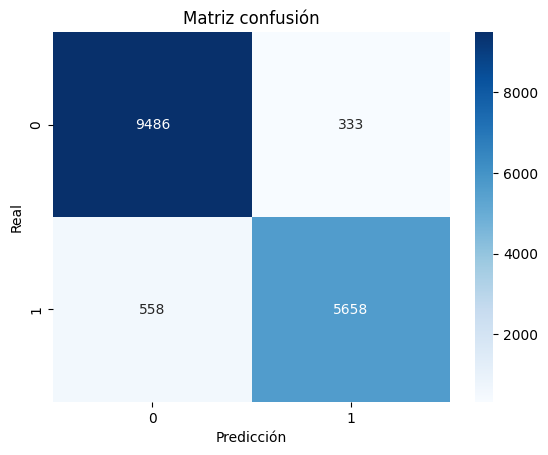

In [13]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz confusión')

De acuerdo a la matriz de confusión, podemos observar que el modelo tuvo un desempeño aceptable, teniendo 9486 predicciones reales correctas y 5658 predicciones negativas correctas. Sin embargo, también tuvo 558 predicciones positivas incorrectas y 333 predicciones negativas incorrectas, lo que indica que el modelo no es perfecto y puede mejorar en la clasificación de las viviendas con acceso a servicios básicos.